In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
red = mpl.rcParams['axes.prop_cycle'].by_key()['color'][0]
blue = mpl.rcParams['axes.prop_cycle'].by_key()['color'][1]
purple = mpl.rcParams['axes.prop_cycle'].by_key()['color'][2]

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

c:\Users\madsh\anaconda3\envs\AML\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\madsh\anaconda3\envs\AML\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\madsh\anaconda3\envs\AML\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Group fairness' robustness on *student dropout* dataset

In this notebook, we work with the *student dropout* dataset. We start by loading and processing the data. Exploratory data analysis for the dataset can be found in *[eda_dropout](notebooks/eda_dropout.ipynb)*. We then create a baseline, evaluate the performance, fairness and feature importance of the model. Afterwards, we repeat but with a fairness constrained model, constrained on being fair for gender. We then similarly evaluate it, and compare the two models. Lastly, we scale the experiment to being fair for gender, age and nationality, to see how the method works in a realistic classification setting.

Start by loading in the data and doing some initial processing.

In [2]:
dropout = pd.read_csv('data/dropout.csv')

dropout = dropout.drop(dropout[dropout.Target=='Enrolled'].index)

dropout["Target"] = dropout["Target"].replace({"Dropout": 1, "Graduate": 0})

dropout["gender_group"] = dropout.Gender.map({1: 0, 0: 1})
dropout.rename({'Nacionality': 'Nationality'}, axis=1, inplace=True)
dropout["age_group"] = dropout["Age at enrollment"].apply(lambda x: 1 if x < 35 else 0)
dropout["nationality_group"] = dropout["Nationality"].apply(lambda x: 1 if x == 1 else 0)

groups = ["gender_group","nationality_group", "age_group"]


dropout.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,gender_group,age_group,nationality_group
0,1,8,5,2,1,1,1,13,10,6,...,0,0.000000,0,10.8,1.4,1.74,1,0,1,1
1,1,6,1,11,1,1,1,1,3,4,...,6,13.666667,0,13.9,-0.3,0.79,0,0,1,1
2,1,1,5,5,1,1,1,22,27,10,...,0,0.000000,0,10.8,1.4,1.74,1,0,1,1
3,1,8,2,15,1,1,1,23,27,6,...,5,12.400000,0,9.4,-0.8,-3.12,0,1,1,1
4,2,12,1,3,0,1,1,22,28,10,...,6,13.000000,0,13.9,-0.3,0.79,0,1,0,1


Define which columns are going to be used for classification, whether they're going to get categorical or continuous preprocessing, and the groups used for debiasing.


In [3]:
nom_features = ["Marital status","Application mode","Application order","Previous qualification"
                ,"Displaced","Educational special needs","Debtor","Tuition fees up to date","Scholarship holder","International"]
num_features = ["Unemployment rate","GDP"]
target = "Target"


For our preprocessing pipeline, we one-hot encode categorical features and standardscale all numerical features. Normally, when onehot encoding, we'd drop first for interpretability. However, since we're doing cross validation, we encode all values as features, and drop any features that are uknown in the validation set. Additionally, normally, we'd split the dataset into train and test. However, here, we're just interested in evaluating the robustness of the methods, and as such, we strictly use cross validation.  

In [4]:
preprocessing = ColumnTransformer(
    [('onehotencoder', OneHotEncoder(handle_unknown='ignore'), nom_features),
     ('standardscaler', StandardScaler(), num_features)
     ])

Throughout the project, we must evaluate the fairness of models. For this, we need to define which fairness criteria to fulfill. For this project, since we're using a group fairness constraint, we evaluate the fairness through *equalized odds*. It specifies the true positive ratio and false positive ratio for 2 groups must be equivalent.

$$
P(R=+|Y=y, A=a) = P(R=+|Y=y, A=b) \; y \in \{+, -\} \; \forall a,b \in A
$$

In [5]:
def equalized_odds(y_true, y_pred, groups):
    mask = groups == 0
    return y_pred[mask & (y_true == 1)].mean(), y_pred[~mask & (y_true == 1)].mean(), y_pred[mask & (y_true == 0)].mean(), y_pred[~mask & (y_true == 0)].mean()

### Baseline
For future reference, we start by making a baseline model without any fairness considerations to see what the performance and fairness of the model looks like.

The baseline is a binary logistic regression model. We implement it in pytorch as a single feed forward layer followed by sigmoid. We also implement a fit method for training the classifier. Since the original paper we base our research on uses l2-regularization, we also use it with regularization strength $\lambda = 0.01$.

In [6]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self,
                 in_dim: int):
        super().__init__()
        
        self.linear = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x)).flatten()
    
    def fit(self, x, y, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10):
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y in trainloader:
                y_pred = self(x)
                loss = criterion(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


For easy tracking across models and k-folds, we implement a *KfoldTracker* to track performance, fairness and feature importance.

In [7]:
class KfoldTracker:
    def __init__(self):
        self.performance = defaultdict(list)
        self.fairness = defaultdict(list)
        self.feature_importance = defaultdict(list)
        self.group_tracker = defaultdict(KfoldTracker)

    def log_performance(self, y_true, y_pred):
        self.performance['Accuracy'].append(accuracy_score(y_true, y_pred))
        self.performance['Balanced accuracy'].append(balanced_accuracy_score(y_true, y_pred))
        self.performance['f1-score'].append(f1_score(y_true, y_pred))
        self.performance['ROC AUC'].append(roc_auc_score(y_true, y_pred))
        
    def log_fairness(self, y_true, y_pred, groups):
        for i in range(groups.shape[1]):
            tpr_g1, tpr_g2, fpr_g1, fpr_g2 = equalized_odds(y_true, y_pred, groups[:, i])
            self.group_tracker[f'group_{i}'].fairness['TPR G1'].append(tpr_g1)
            self.group_tracker[f'group_{i}'].fairness['TPR G2'].append(tpr_g2)
            self.group_tracker[f'group_{i}'].fairness['FPR G1'].append(fpr_g1)
            self.group_tracker[f'group_{i}'].fairness['FPR G2'].append(fpr_g2)

    def log_feature_importance(self, feature_importance, feature_names):
        for i, name in enumerate(feature_names):
            self.feature_importance[name].append(feature_importance[i])
        for key in self.feature_importance.keys():
            if key not in feature_names:
                self.feature_importance[key].append(np.nan)

    def log(self, y_true, y_pred, groups, feature_importance, feature_names):
        self.log_performance(y_true, y_pred)
        self.log_fairness(y_true, y_pred, groups)
        self.log_feature_importance(feature_importance, feature_names)

    def get_mean_performance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.performance.items()}

    def get_mean_group_performance(self, group_name):
        return {k: (np.mean(v), np.std(v)) for k, v in self.group_performance[group_name].items()}
    
    def get_mean_fairness(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.fairness.items()}
    
    def get_mean_feature_importance(self):
        return {k: (np.nanmean(v), np.std(v)) for k, v in self.feature_importance.items()}

    def __str__(self):
        return str(pd.DataFrame(self.performance).T) + '\n\n' + str(pd.DataFrame(self.fairness).T)
    
    def __getitem__(self, key):
        return self.group_tracker[key]

We train the baseline classifier with k-fold cross validation with $k=10$. This allows us to evaluate the models performance on different train-validation splits, and the uncertainty associated with it. 

In [8]:
tracker_base = KfoldTracker()

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(dropout)):
    train = dropout.iloc[train_idx]
    val = dropout.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = BinaryLogisticRegression(x_train.shape[1])
    model.fit(x_train, y_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_base.log(y_val, y_pred, g_val, feature_importance, feature_names)

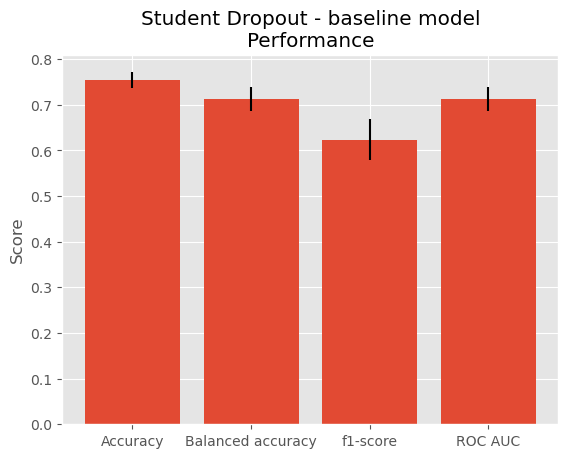

In [9]:
perf_base = tracker_base.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_base.keys(), [v[0] for v in perf_base.values()], yerr=[v[1] for v in perf_base.values()])
ax.set_title('Student Dropout - baseline model\nPerformance')
ax.set_ylabel('Score')

FIG_PATH = 'reports/figs/dropout'
def savefig(fname, dpi=None):
    dpi = 150 if dpi == None else dpi
    plt.savefig(os.path.join(FIG_PATH, fname), bbox_inches='tight', dpi=dpi)
    
savefig('baseline_performance.svg')

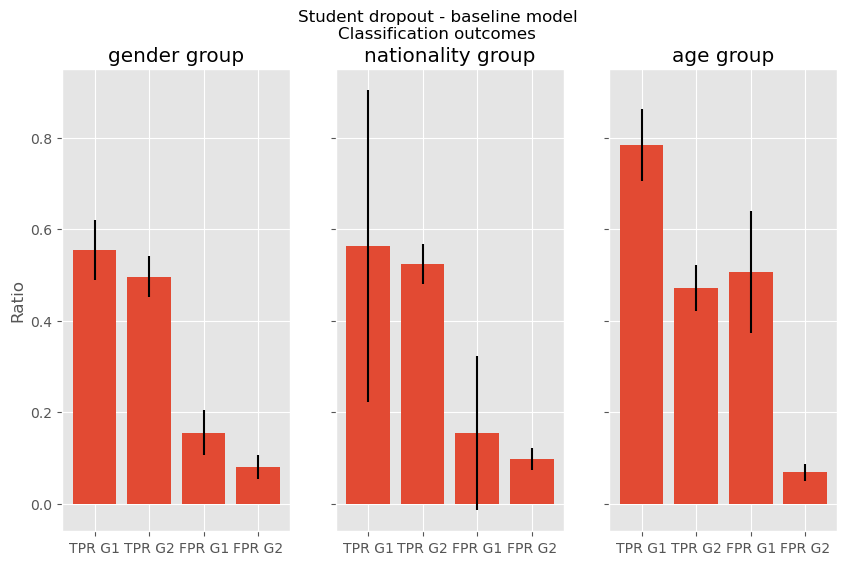

In [10]:
def plot_outcomes(tracker):
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 6))
    for i in range(len(groups)):
        fairness = tracker[f'group_{i}'].get_mean_fairness()
        axs[i].bar(fairness.keys(), [v[0] for v in fairness.values()], yerr=[v[1] for v in fairness.values()])
        axs[i].set_title(f'{groups[i]}'.replace('_', ' '))
    axs[0].set_ylabel('Ratio')
    return fig, axs

fig, axs = plot_outcomes(tracker_base)

fig.suptitle('Student dropout - baseline model\nClassification outcomes')
savefig('baseline_fairness.svg')

We evaluate feature importance across all k-folds, and use the multiple folds for estimating the uncertainty of the model. Since we're using a logistic regression model, we can calculate the odds ratio between $x$ and $x'$, where $x$ and $x'$ are identical except for one feature, as:

$$
\frac{odds(x')}{odds(x)} = e^{\beta_j}
$$


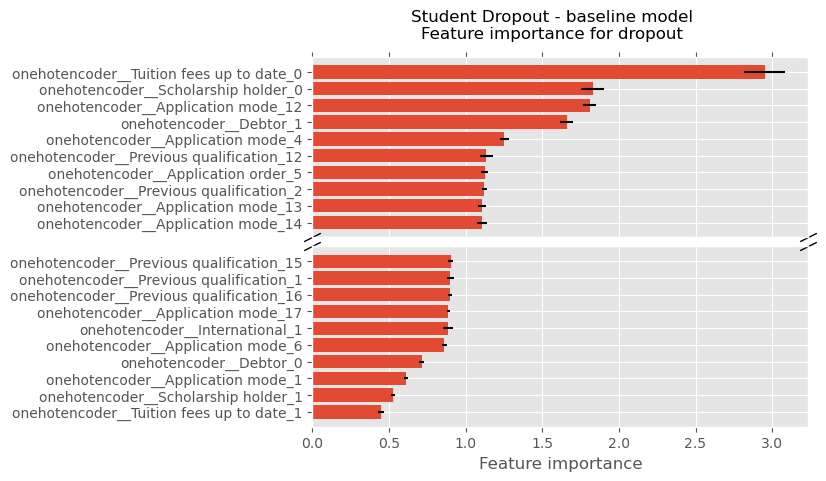

In [11]:
def plot_feature_importance(feature_importance):

    means = np.array([value[0] for value in feature_importance.values()])
    stds = np.array([value[1] for value in feature_importance.values()])
    keys = np.array(list(feature_importance.keys()))

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.05)
    idx = np.argsort(means)
    idx = np.concatenate((idx[:10], idx[-10:]))

    ax1.barh(keys[idx[10:]], means[idx[10:]], xerr=stds[idx[10:]])
    ax2.barh(keys[idx[:10]], means[idx[:10]], xerr=stds[idx[:10]])

    ax1.xaxis.tick_top()

    d = .5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    return fig, (ax1, ax2)

feature_importance_base = tracker_base.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_base)
ax2.set_xlabel('Feature importance')
fig.suptitle('Student Dropout - baseline model\nFeature importance for dropout')
savefig('baseline_feature_importance.svg')

### Fair model - enforcing fairness through constrained optimization

To debias models, we implement the group fairness constraint from:

Richard Berk, Hoda Heidari, Shahin Jabbari, Matthew Joseph, Michael Kearns, Jamie Morgenstern, Seth
Neel, and Aaron Roth. A convex framework for fair regression. arXiv preprint arXiv:1706.02409, 2017.

$$
f_2(\mathbf{w}, S)=\left(\frac{1}{n_1 n_2} \sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

This cost function does not work in our setting. We initially tested with it, but we experienced that it didn't work for us (for more info, see *[true_constraint.ipynb](notebooks/true_constraint.ipynb)*). Instead, we let *g* be our decision function $g(x) = \frac{1}{1 + e^{-(wx)}}$, and implement the loss as:

$$
f_2(\mathbf{w}, S)=\frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(g(\mathbf{x}_i) - g(\mathbf{x}_j) \right)\right)^2
$$

We implement this as an optimization constrain for our fair model, such that we use it as a regulerization term, with parameter $\gamma$ used as regulerization strength. As such, the loss function we're optimizing becomes.

$$
\mathcal{L} = - \frac{1}{N} \left[ \sum_{i=1}^N y_i \; log \, g_\beta(\mathbf{x}_i) + (1 - y_i) \; log \, (1-g_\beta(\mathbf{x}_i)) \right] 
+ 
\gamma \left( \frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left( g_\beta(\mathbf{x}_i) - g_\beta(\mathbf{x}_j) \right)\right)^2 \right) + \lambda ||\beta||_2
$$

In [12]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    def forward(self, y_pred, y_true, groups):
        mask = groups == 0
        S_pred_1, S_true_1 = y_pred[mask],  y_true[mask]
        S_pred_2, S_true_2 = y_pred[~mask], y_true[~mask]
        
        n_1 = S_pred_1.shape[0]
        n_2 = S_pred_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_true_1[idx1], S_true_2[idx2]) * (S_pred_1[idx1] - S_pred_2[idx2])
        cost = vector.sum()
        cost = cost ** 2
        cost = cost / (n_1*n_2)

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    
class FairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
    
    def fit(self, x, y, g, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, g), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = self.gamma * fair_criterion(y_pred, y, g)
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')


We implement a gridsearch for finding the optimal $\gamma$ for the optimal accuracy-fairness tradeoff.

In [13]:
gammaspace = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
trackers = []

for gamma in gammaspace:
    tracker = KfoldTracker()

    n_splits = 5
    splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(splits.split(dropout)):
        train = dropout.iloc[train_idx]
        val = dropout.iloc[val_idx]
        
        x_train = preprocessing.fit_transform(train).toarray()
        y_train = train[target].values
        g_train = train[groups].values
        
        x_val = preprocessing.transform(val).toarray()
        y_val = val[target].values
        g_val = val[groups].values

        x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

        model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
        model.fit(x_train, y_train, g_train[:, 0])
        
        y_pred = model(x_val)
        y_pred = y_pred.detach().numpy().round()

        feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
        feature_names = preprocessing.get_feature_names_out()
        tracker.log(y_val, y_pred, g_val, feature_importance, feature_names)

        mask = g_val[:, 0] == 0
        tracker['male'].log_performance(y_val[mask], y_pred[mask])
        tracker['female'].log_performance(y_val[~mask], y_pred[~mask])

    trackers.append(tracker)


We plot the gamma search in pareto curves to find the optimal gamma value. We plot the f1-score for each group along with the true positive ratios, such that we can identify the point of equalized opportunity. 

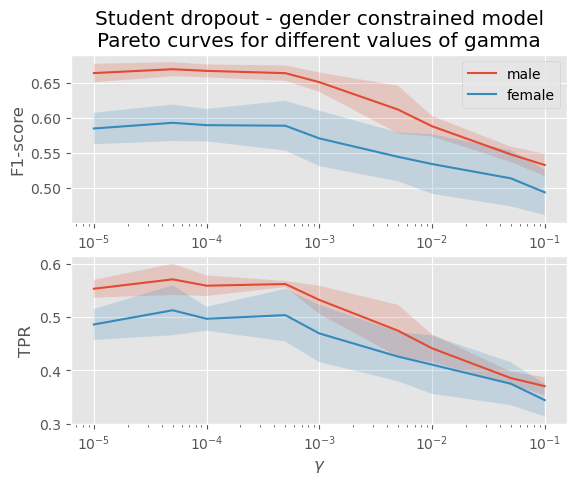

In [14]:
male_perf = np.array([t['male'].get_mean_performance()['f1-score'][0] for t in trackers])
female_perf = np.array([t['female'].get_mean_performance()['f1-score'][0] for t in trackers])

male_unc = np.array([t['male'].get_mean_performance()['f1-score'][1] for t in trackers])
female_unc = np.array([t['female'].get_mean_performance()['f1-score'][1] for t in trackers])

tpr_g1 = np.array([t['group_0'].get_mean_fairness()['TPR G1'][0] for t in trackers])
tpr_g2 = np.array([t['group_0'].get_mean_fairness()['TPR G2'][0] for t in trackers])
tpr_g1_unc = np.array([t['group_0'].get_mean_fairness()['TPR G1'][1] for t in trackers])
tpr_g2_unc = np.array([t['group_0'].get_mean_fairness()['TPR G2'][1] for t in trackers])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gammaspace, male_perf, label='male')
ax1.plot(gammaspace, female_perf, label='female')

ax1.fill_between(gammaspace, male_perf + male_unc, male_perf - male_unc, alpha=0.2)
ax1.fill_between(gammaspace, female_perf + female_unc, female_perf - female_unc, alpha=0.2)

ax1.set_xscale('log')

ax1.set_ylabel('F1-score')

ax1.legend()

ax1.set_title('Student dropout - gender constrained model\nPareto curves for different values of gamma')

ax2.plot(gammaspace, tpr_g1, label='TPR G1')
ax2.plot(gammaspace, tpr_g2, label='TPR G2')

ax2.fill_between(gammaspace, tpr_g1 + tpr_g1_unc, tpr_g1 - tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, tpr_g2 + tpr_g2_unc, tpr_g2 - tpr_g2_unc, alpha=0.2)

ax2.set_xscale('log')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('TPR')

savefig("gender_constrained_pareto.svg")

By investigating the pareto curves empirically, we see that there is no clear optimal gamma value. However $\gamma = 0.01$ appears to achieve the best tradeoff between performance and fairness. We train a new model with this gamma value. 

In [15]:
tracker_fair = KfoldTracker()

gamma = 1e-2

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(dropout)):
    train = dropout.iloc[train_idx]
    val = dropout.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
    model.fit(x_train, y_train, g_train[:, 0])
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_fair.log(y_val, y_pred, g_val, feature_importance, feature_names)

With this model, we evaluate the performance, fairness and feature importance. 

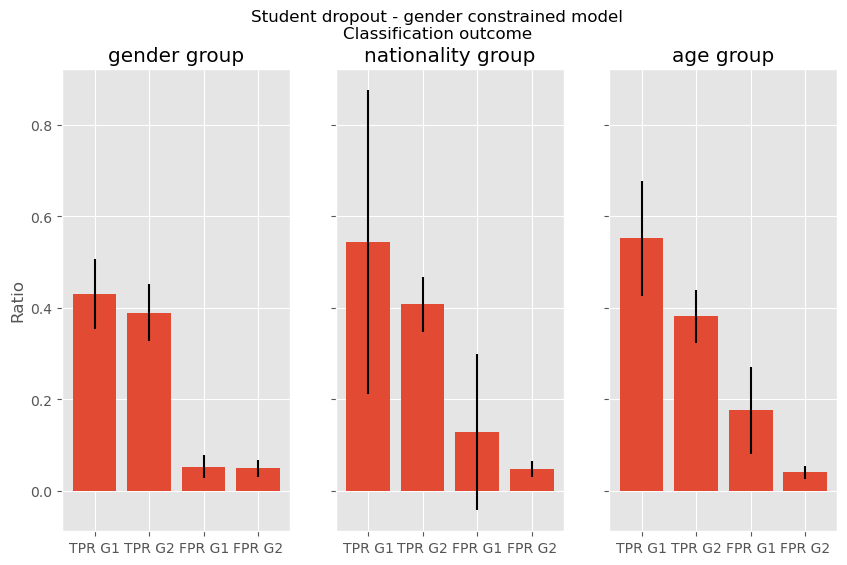

In [16]:
fig, axs = plot_outcomes(tracker_fair)

fig.suptitle('Student dropout - gender constrained model\nClassification outcome')
savefig('constrained_fairness.svg')

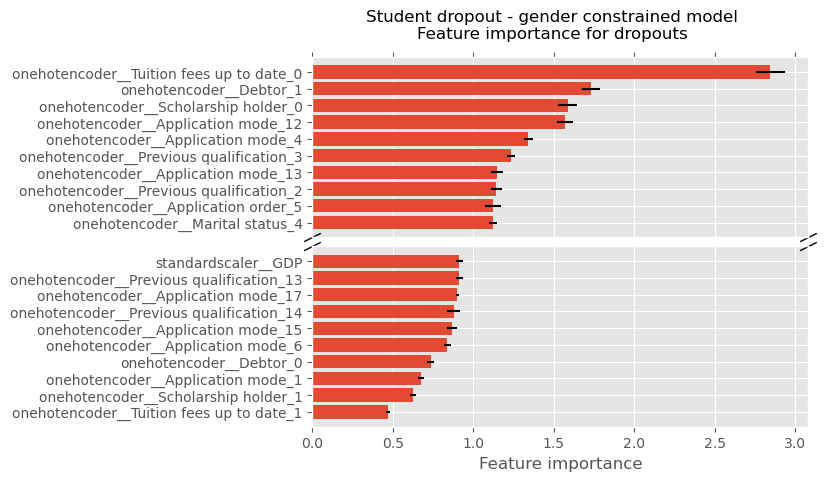

In [17]:
feature_importance_fair = tracker_fair.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_fair)
ax2.set_xlabel('Feature importance')
fig.suptitle('Student dropout - gender constrained model\nFeature importance for dropouts')
savefig('constrained_feature_importance.svg')

### Application of method on 3 protected groups
We repeat the experiment from before, but now we do it in a more realistic manner; we apply the group fairness penalty on 3 groups under optimization.

We start by making our other groups binary. 

We define a model that supports fairness regularization on any number of groups

In [18]:
class VeryFairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
    
    def fit(self, x, y, gs, lr=0.01, weight_decay=0.01, batch_size=128, n_iter=10, verbose=False):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        trainloader = DataLoader(TensorDataset(x, y, gs), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss_bce = criterion(y_pred, y)
                loss_fair = sum([self.gamma * fair_criterion(y_pred, y, g[:, idx]) for idx in range(g.shape[1])])
                loss = loss_bce + loss_fair

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print(f'Epoch: {epoch}, Loss BCE: {round(loss_bce.item(), 4)}, Loss Fair: {round(loss_fair.item(), 4)}')


We gridsearch to find the optimal regularization strength for each group

In [19]:
gammaspace = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
trackers = []

for gamma in gammaspace:
    tracker = KfoldTracker()

    n_splits = 5
    splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(splits.split(dropout)):
        train = dropout.iloc[train_idx]
        val = dropout.iloc[val_idx]
        
        x_train = preprocessing.fit_transform(train).toarray()
        y_train = train[target].values
        g_train = train[groups].values
        
        x_val = preprocessing.transform(val).toarray()
        y_val = val[target].values
        g_val = val[groups].values

        x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

        model = VeryFairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
        model.fit(x_train, y_train, g_train)
        
        y_pred = model(x_val)
        y_pred = y_pred.detach().numpy().round()

        feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
        feature_names = preprocessing.get_feature_names_out()
        tracker.log(y_val, y_pred, g_val, feature_importance, feature_names)

        mask = g_val[:, 0] == 0
        tracker['male'].log_performance(y_val[mask], y_pred[mask])
        tracker['female'].log_performance(y_val[~mask], y_pred[~mask])

        mask = g_val[:, 1] == 0
        tracker['majority_nationality'].log_performance(y_val[mask], y_pred[mask])
        tracker['other_nationality'].log_performance(y_val[~mask], y_pred[~mask])

        mask = g_val[:, 2] == 0
        tracker['<35'].log_performance(y_val[mask], y_pred[mask])
        tracker['>=35'].log_performance(y_val[~mask], y_pred[~mask])

    trackers.append(tracker)

We plot the f1-score and tpr of the models with different regularization strengths in a pareto curve. 

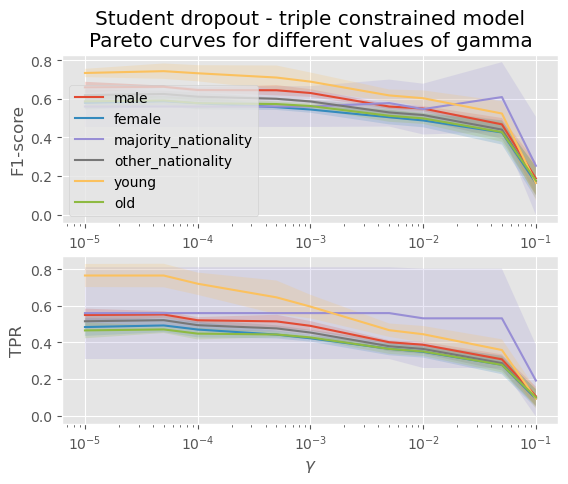

In [20]:
male_perf = np.array([t['male'].get_mean_performance()['f1-score'][0] for t in trackers])
female_perf = np.array([t['female'].get_mean_performance()['f1-score'][0] for t in trackers])
male_unc = np.array([t['male'].get_mean_performance()['f1-score'][1] for t in trackers])
female_unc = np.array([t['female'].get_mean_performance()['f1-score'][1] for t in trackers])

majority_nationality_perf = np.array([t['majority_nationality'].get_mean_performance()['f1-score'][0] for t in trackers])
other_nationality_perf = np.array([t['other_nationality'].get_mean_performance()['f1-score'][0] for t in trackers])
majority_nationality_unc = np.array([t['majority_nationality'].get_mean_performance()['f1-score'][1] for t in trackers])
other_nationality_unc = np.array([t['other_nationality'].get_mean_performance()['f1-score'][1] for t in trackers])

young_perf = np.array([t['<35'].get_mean_performance()['f1-score'][0] for t in trackers])
old_perf = np.array([t['>=35'].get_mean_performance()['f1-score'][0] for t in trackers])
young_unc = np.array([t['<35'].get_mean_performance()['f1-score'][1] for t in trackers])
old_unc = np.array([t['>=35'].get_mean_performance()['f1-score'][1] for t in trackers])

gender_tpr_g1 = np.array([t['group_0'].get_mean_fairness()['TPR G1'][0] for t in trackers])
gender_tpr_g2 = np.array([t['group_0'].get_mean_fairness()['TPR G2'][0] for t in trackers])
gender_tpr_g1_unc = np.array([t['group_0'].get_mean_fairness()['TPR G1'][1] for t in trackers])
gender_tpr_g2_unc = np.array([t['group_0'].get_mean_fairness()['TPR G2'][1] for t in trackers])

nationality_tpr_g1 = np.array([t['group_1'].get_mean_fairness()['TPR G1'][0] for t in trackers])
nationality_tpr_g2 = np.array([t['group_1'].get_mean_fairness()['TPR G2'][0] for t in trackers])
nationality_tpr_g1_unc = np.array([t['group_1'].get_mean_fairness()['TPR G1'][1] for t in trackers])
nationality_tpr_g2_unc = np.array([t['group_1'].get_mean_fairness()['TPR G2'][1] for t in trackers])

age_tpr_g1 = np.array([t['group_2'].get_mean_fairness()['TPR G1'][0] for t in trackers])
age_tpr_g2 = np.array([t['group_2'].get_mean_fairness()['TPR G2'][0] for t in trackers])
age_tpr_g1_unc = np.array([t['group_2'].get_mean_fairness()['TPR G1'][1] for t in trackers])
age_tpr_g2_unc = np.array([t['group_2'].get_mean_fairness()['TPR G2'][1] for t in trackers])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(gammaspace, male_perf, label='male')
ax1.plot(gammaspace, female_perf, label='female')

ax1.fill_between(gammaspace, male_perf + male_unc, male_perf - male_unc, alpha=0.2)
ax1.fill_between(gammaspace, female_perf + female_unc, female_perf - female_unc, alpha=0.2)

ax1.plot(gammaspace, majority_nationality_perf, label='majority_nationality')
ax1.plot(gammaspace, other_nationality_perf, label='other_nationality')

ax1.fill_between(gammaspace, majority_nationality_perf + majority_nationality_unc, majority_nationality_perf - majority_nationality_unc, alpha=0.2)
ax1.fill_between(gammaspace, other_nationality_perf + other_nationality_unc, other_nationality_perf - other_nationality_unc, alpha=0.2)

ax1.plot(gammaspace, young_perf, label='young')
ax1.plot(gammaspace, old_perf, label='old')

ax1.fill_between(gammaspace, young_perf + young_unc, young_perf - young_unc, alpha=0.2)
ax1.fill_between(gammaspace, old_perf + old_unc, old_perf - old_unc, alpha=0.2)

ax1.set_xscale('log')

ax1.set_ylabel('F1-score')

ax1.legend()

ax1.set_title('Student dropout - triple constrained model\nPareto curves for different values of gamma')

ax2.plot(gammaspace, gender_tpr_g1, label='TPR G1')
ax2.plot(gammaspace, gender_tpr_g2, label='TPR G2')
ax2.fill_between(gammaspace, gender_tpr_g1 + gender_tpr_g1_unc, gender_tpr_g1 - gender_tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, gender_tpr_g2 + gender_tpr_g2_unc, gender_tpr_g2 - gender_tpr_g2_unc, alpha=0.2)

ax2.plot(gammaspace, nationality_tpr_g1, label='TPR G1')
ax2.plot(gammaspace, nationality_tpr_g2, label='TPR G2')
ax2.fill_between(gammaspace, nationality_tpr_g1 + nationality_tpr_g1_unc, nationality_tpr_g1 - nationality_tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, nationality_tpr_g2 + nationality_tpr_g2_unc, nationality_tpr_g2 - nationality_tpr_g2_unc, alpha=0.2)

ax2.plot(gammaspace, age_tpr_g1, label='TPR G1')
ax2.plot(gammaspace, age_tpr_g2, label='TPR G2')
ax2.fill_between(gammaspace, age_tpr_g1 + age_tpr_g1_unc, age_tpr_g1 - age_tpr_g1_unc, alpha=0.2)
ax2.fill_between(gammaspace, age_tpr_g2 + age_tpr_g2_unc, age_tpr_g2 - age_tpr_g2_unc, alpha=0.2)

ax2.set_xscale('log')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('TPR')

savefig('pareto_curves_triple_constrained.svg')

In [21]:
tracker_3 = KfoldTracker()

gamma = 5e-3

n_splits = 10
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(dropout)):
    train = dropout.iloc[train_idx]
    val = dropout.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = VeryFairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
    model.fit(x_train, y_train, g_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_3.log(y_val, y_pred, g_val, feature_importance, feature_names) 

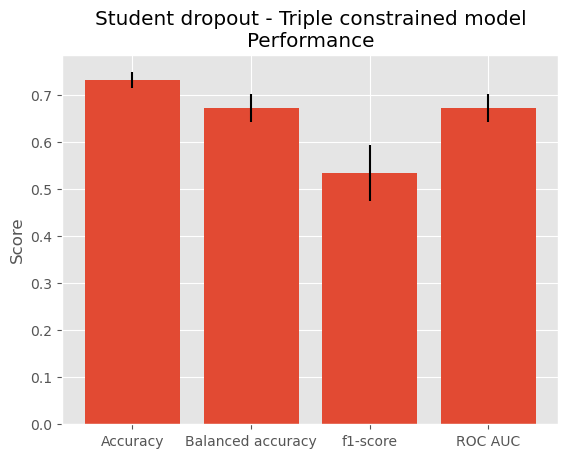

In [22]:
perf_3 = tracker_3.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_3.keys(), [v[0] for v in perf_3.values()], yerr=[v[1] for v in perf_3.values()])
ax.set_title('Student dropout - Triple constrained model\nPerformance')
ax.set_ylabel('Score')
savefig('triple_constrained_performance.svg')

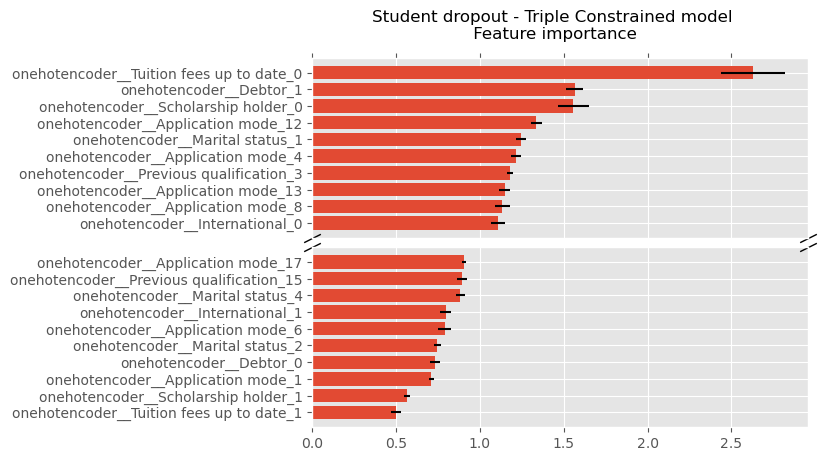

In [23]:
feature_importance_3 = tracker_3.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_3)
fig.suptitle('Student dropout - Triple Constrained model\n Feature importance')
savefig('triple_constrained_feature_importance.svg')

Comparison across all three models

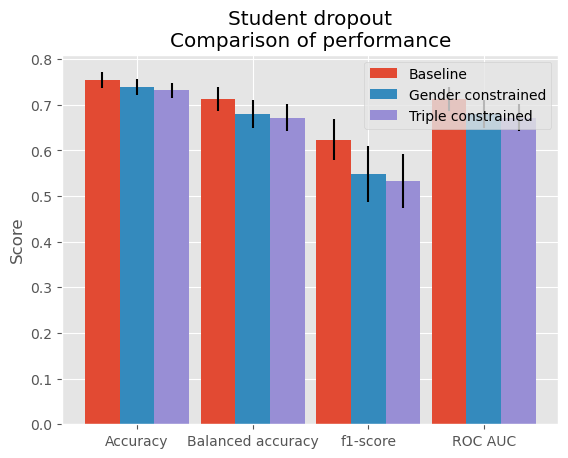

In [24]:
fig, ax = plt.subplots()

categories = np.array(list(tracker_base.get_mean_performance().keys()))

perf_base = [v[0] for v in tracker_base.get_mean_performance().values()]
perf_fair = [v[0] for v in tracker_fair.get_mean_performance().values()]
perf_3 = [v[0] for v in tracker_3.get_mean_performance().values()]

unc_base = [v[1] for v in tracker_base.get_mean_performance().values()]
unc_fair = [v[1] for v in tracker_fair.get_mean_performance().values()]
unc_3 = [v[1] for v in tracker_3.get_mean_performance().values()]

x_axis = np.arange(len(categories))
ax.bar(x_axis-.3, perf_base, yerr=unc_base, width=.3, label='Baseline')
ax.bar(x_axis, perf_fair, yerr=unc_fair, width=.3, label='Gender constrained')
ax.bar(x_axis+.3, perf_3, yerr=unc_3, width=.3, label='Triple constrained')

ax.set_xticks(x_axis)
ax.set_xticklabels(categories)
ax.set_ylabel('Score')
ax.legend()

ax.set_title('Student dropout\nComparison of performance')
savefig('performance_comparison.svg')

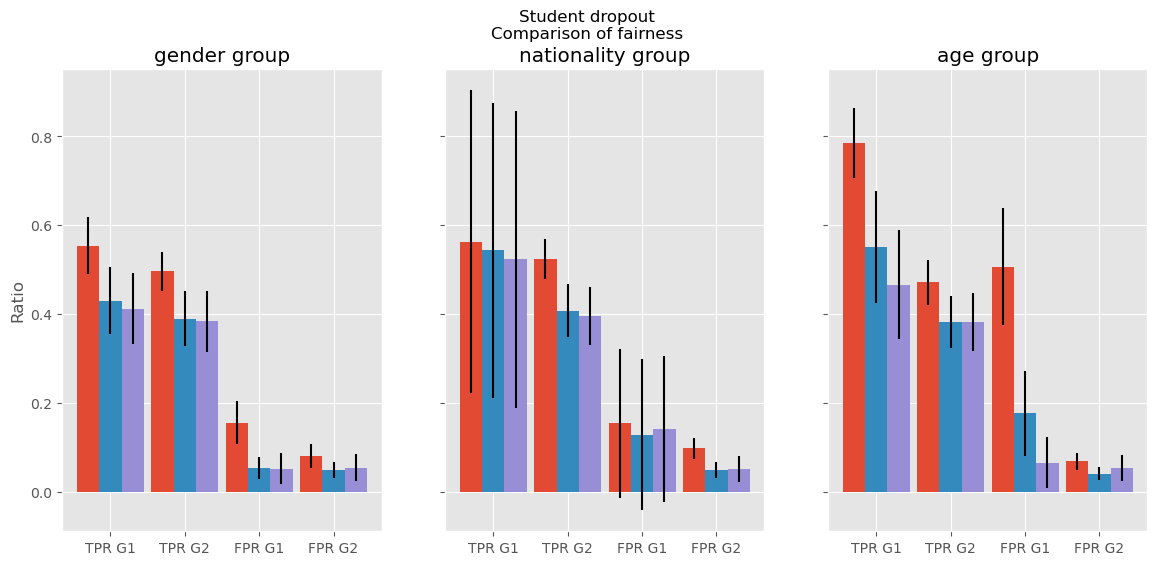

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
bin_width = .3

x_axis = np.arange(len(tracker_base[f'group_{0}'].get_mean_fairness().keys()))

for i in range(len(groups)):
    fairness = tracker_base[f'group_{i}'].get_mean_fairness()
    axs[i].bar(x_axis - bin_width, [v[0] for v in fairness.values()], yerr=[v[1] for v in fairness.values()], width=bin_width, color=red, label='Baseline')
    axs[i].set_title(f'{groups[i]}'.replace('_', ' '))

for i in range(len(groups)):
    fairness = tracker_fair[f'group_{i}'].get_mean_fairness()
    axs[i].bar(x_axis, [v[0] for v in fairness.values()], yerr=[v[1] for v in fairness.values()], width=bin_width, color=blue, label='Gender constrained')
    axs[i].set_title(f'{groups[i]}'.replace('_', ' '))

for i in range(len(groups)):
    fairness = tracker_3[f'group_{i}'].get_mean_fairness()
    axs[i].bar(x_axis + bin_width, [v[0] for v in fairness.values()], yerr=[v[1] for v in fairness.values()], width=bin_width, color=purple, label='Triple constrained')
    axs[i].set_title(f'{groups[i]}'.replace('_', ' '))

for ax in axs:
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(tracker_base[f'group_{0}'].get_mean_fairness().keys())

axs[0].set_ylabel('Ratio')
fig.suptitle('Student dropout\nComparison of fairness')
savefig('fairness_comparison.svg')

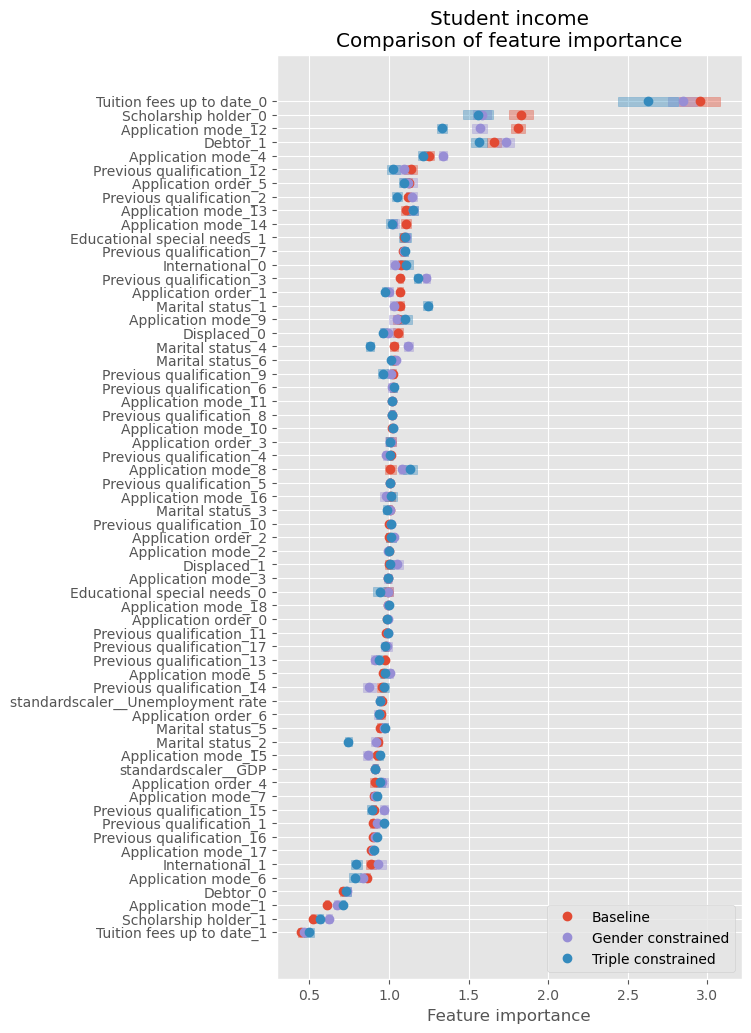

In [26]:
categories = np.array(list(feature_importance_base.keys()))
values_base = np.array([v[0] for v in feature_importance_base.values()])
values_fair = np.array([v[0] for v in feature_importance_fair.values()])
values_3 = np.array([v[0] for v in feature_importance_3.values()])
uncertainty_base = np.array([v[1] for v in feature_importance_base.values()])
uncertainty_fair = np.array([v[1] for v in feature_importance_fair.values()])
uncertainty_3 = np.array([v[1] for v in feature_importance_3.values()])

categories = np.array([cat.split('__')[1] if 'onehotencoder' in cat else cat for cat in categories])

idx = np.argsort(values_base)
categories, values_base, values_fair, values_3, uncertainty_base, uncertainty_fair, uncertainty_3 = map(lambda x: x[idx], (categories, values_base, values_fair, values_3, uncertainty_base, uncertainty_fair, uncertainty_3))

fig, ax = plt.subplots(figsize=(6, 12))

for i in range(len(categories)):
    ax.plot(values_base[i], i, 'o', color=red, label='Baseline' if i == 0 else None)
    ax.plot(values_fair[i], i, 'o', color=purple, label='Gender constrained' if i == 0 else None)
    ax.plot(values_3[i], i, 'o', color=blue, label='Triple constrained' if i == 0 else None)
    ax.fill_betweenx([i-0.33, i+0.33], values_base[i]-uncertainty_base[i], values_base[i]+uncertainty_base[i], color=red, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_fair[i]-uncertainty_fair[i], values_fair[i]+uncertainty_fair[i], color=purple, alpha=0.4)
    ax.fill_betweenx([i-0.33, i+0.33], values_3[i]-uncertainty_3[i], values_3[i]+uncertainty_3[i], color=blue, alpha=0.4)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Feature importance')

ax.set_title('Student income\nComparison of feature importance')

ax.legend()

savefig('feature_importance_comparison.svg')